# Лабораторна робота №3: Агенти на основі знань

## Мета роботи
Удосконалити інтелектуального агента з попередньої лабораторної роботи, щоб агент створював та використовував власну базу знань для орієнтування та побудови маршруту.

## Завдання
- Отримати навички роботи з базами знань
- Удосконалити агента-автомобіля з попередньої лабораторної роботи

In [1]:
!pip3 install matplotlib networkx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import random
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple, Set, Dict, Any
from collections import deque, defaultdict
import time
import json

## База знань

In [3]:
class KnowledgeBase:
    def __init__(self):
        self.facts = set()
        self.graph_connections = defaultdict(set)
        self.road_signs = {}
        self.visited_intersections = set()
        
    def tell(self, fact):
        if isinstance(fact, dict):
            fact_type = fact.get('type')
            if fact_type == 'connection':
                from_node = fact['from']
                to_node = fact['to']
                self.graph_connections[from_node].add(to_node)
                self.facts.add(f"connected({from_node}, {to_node})")
                
            elif fact_type == 'road_sign':
                road = fact['road']
                target_intersection = fact['target']
                available_directions = fact['directions']
                self.road_signs[road] = {
                    'target': target_intersection,
                    'directions': available_directions
                }
                self.facts.add(f"road_sign({road}, {target_intersection}, {available_directions})")
                
            elif fact_type == 'visited':
                intersection = fact['intersection']
                self.visited_intersections.add(intersection)
                self.facts.add(f"visited({intersection})")
        else:
            self.facts.add(str(fact))
            
    def ask(self, query):
        if isinstance(query, dict):
            query_type = query.get('type')
            
            if query_type == 'path_to_target':
                start = query['start']
                target = query['target']
                return self._find_path_with_knowledge(start, target)
                
            elif query_type == 'best_exploration':
                current = query['current']
                return self._suggest_exploration(current)
                
            elif query_type == 'road_sign_info':
                road = query['road']
                return self.road_signs.get(road, None)
                
        return None
        
    def _find_path_with_knowledge(self, start, target):
        if start == target:
            return [start]
            
        queue = deque([(start, [start])])
        visited = {start}
        
        while queue:
            node, path = queue.popleft()
            
            for neighbor in self.graph_connections[node]:
                if neighbor == target:
                    return path + [neighbor]
                    
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))
        
        return None
        
    def _suggest_exploration(self, current):
        available = list(self.graph_connections[current])
        unvisited = [node for node in available if node not in self.visited_intersections]
        
        if unvisited:
            return random.choice(unvisited)
        elif available:
            return random.choice(available)
        return None
        
    def get_known_connections(self, node):
        return list(self.graph_connections[node])
        
    def is_intersection_known(self, node):
        return node in self.visited_intersections

## Граф з дорожніми знаками

In [4]:
class RoadGraphWithSigns:
    def __init__(self, size: int, edges_to_remove: int = 0):
        self.size = size
        self.edges_to_remove = edges_to_remove
        self.graph = {}
        self.removed_edges = set()
        self.road_signs = {}
        self.generate_grid_graph()
        self.generate_road_signs()
        
    def generate_grid_graph(self):
        for i in range(self.size):
            for j in range(self.size):
                node = (i, j)
                self.graph[node] = []
                
                if j < self.size - 1:
                    neighbor = (i, j + 1)
                    self.graph[node].append(neighbor)
                
                if i < self.size - 1:
                    neighbor = (i + 1, j)
                    self.graph[node].append(neighbor)
                
                if j > 0:
                    neighbor = (i, j - 1)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
                
                if i > 0:
                    neighbor = (i - 1, j)
                    if neighbor not in self.graph[node]:
                        self.graph[node].append(neighbor)
        
        if self.edges_to_remove > 0:
            self.remove_random_edges_safely()
    
    def remove_random_edges_safely(self):
        all_edges = self.get_all_edges()
        total_edges = len(all_edges)
        
        print(f"всього ребер: {total_edges}")
        print(f"запитано видалити: {self.edges_to_remove} ребер")
        
        removed_count = 0
        attempts = 0
        max_attempts = self.edges_to_remove * 100  # збільшуємо кількість спроб
        
        while removed_count < self.edges_to_remove and attempts < max_attempts:
            attempts += 1
            
            # вибираємо випадкове ребро з доступних
            available_edges = [edge for edge in all_edges if tuple(sorted([edge[0], edge[1]])) not in self.removed_edges]
            
            if not available_edges:
                print("немає доступних ребер для видалення")
                break
                
            edge = random.choice(available_edges)
            node1, node2 = edge
            
            # тимчасово видаляємо ребро
            if node2 in self.graph[node1]:
                self.graph[node1].remove(node2)
            if node1 in self.graph[node2]:
                self.graph[node2].remove(node1)
                
            # перевіряємо зв'язність
            if self.is_connected():
                # видалення успішне - зберігаємо зміни
                self.removed_edges.add(tuple(sorted([node1, node2])))
                removed_count += 1
            else:
                # видалення порушило зв'язність - відновлюємо ребро
                if node2 not in self.graph[node1]:
                    self.graph[node1].append(node2)
                if node1 not in self.graph[node2]:
                    self.graph[node2].append(node1)
        
        print(f"фактично видалено: {removed_count} ребер із {self.edges_to_remove} запитаних")
        print(f"граф зв'язний: {'ТАК ✓' if self.is_connected() else 'НІ ✗'}")
        
        # статистика про невдалі спроби
        failed_attempts = attempts - removed_count
        if failed_attempts > 0 and removed_count < self.edges_to_remove:
            print(f"невдалих спроб: {failed_attempts}")
            print(f"можливо, досягнуто максимум видалень для збереження зв'язності")
    
    def get_all_edges(self):
        edges = []
        visited = set()
        for node in self.graph:
            for neighbor in self.graph[node]:
                edge = tuple(sorted([node, neighbor]))
                if edge not in visited:
                    edges.append((node, neighbor))
                    visited.add(edge)
        return edges
    
    def is_connected(self) -> bool:
        if not self.graph:
            return True
        
        start_node = list(self.graph.keys())[0]
        visited = set()
        queue = [start_node]
        
        while queue:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                for neighbor in self.graph[node]:
                    if neighbor not in visited:
                        queue.append(neighbor)
        
        return len(visited) == len(self.graph)
    
    def generate_road_signs(self):
        for node in self.graph:
            for neighbor in self.graph[node]:
                road_key = (node, neighbor)
                target_directions = self.get_directions_at_intersection(neighbor)
                self.road_signs[road_key] = {
                    'target_intersection': neighbor,
                    'available_directions': target_directions
                }
                
    def get_directions_at_intersection(self, intersection):
        neighbors = self.graph.get(intersection, [])
        directions = []
        x, y = intersection
        
        for neighbor in neighbors:
            nx, ny = neighbor
            if nx == x and ny > y:
                directions.append('east')
            elif nx == x and ny < y:
                directions.append('west')
            elif nx > x and ny == y:
                directions.append('south')
            elif nx < x and ny == y:
                directions.append('north')
                
        return directions
    
    def get_road_sign(self, from_node, to_node):
        return self.road_signs.get((from_node, to_node), None)

## Агент на основі знань

In [5]:
class KnowledgeBasedAgent:
    def __init__(self, road_graph: RoadGraphWithSigns, start: Tuple[int, int], target: Tuple[int, int]):
        self.road_graph = road_graph
        self.current_position = start
        self.target_position = target
        self.knowledge_base = KnowledgeBase()
        self.path_history = [start]
        self.steps = 0
        print("kb agent init:", start, "->", target)
        
    def perceive_environment_and_signs(self):
        current = self.current_position
        neighbors = self.road_graph.graph.get(current, [])
        
        self.knowledge_base.tell({
            'type': 'visited',
            'intersection': current
        })
        
        for neighbor in neighbors:
            self.knowledge_base.tell({
                'type': 'connection',
                'from': current,
                'to': neighbor
            })
            
            road_sign = self.road_graph.get_road_sign(current, neighbor)
            if road_sign:
                self.knowledge_base.tell({
                    'type': 'road_sign',
                    'road': (current, neighbor),
                    'target': road_sign['target_intersection'],
                    'directions': road_sign['available_directions']
                })
                print(f"sign: {current}->{neighbor} leads to {road_sign['target_intersection']} with {road_sign['available_directions']}")
        
        return neighbors
    
    def ask_knowledge_base_for_action(self):
        if self.current_position == self.target_position:
            print("kb: target reached")
            return None
        
        path_query = {
            'type': 'path_to_target',
            'start': self.current_position,
            'target': self.target_position
        }
        
        known_path = self.knowledge_base.ask(path_query)
        
        if known_path and len(known_path) > 1:
            next_move = known_path[1]
            print(f"kb: following known path to {next_move}")
            return next_move
        
        exploration_query = {
            'type': 'best_exploration',
            'current': self.current_position
        }
        
        exploration_move = self.knowledge_base.ask(exploration_query)
        if exploration_move:
            print(f"kb: exploring {exploration_move}")
            return exploration_move
            
        print("kb: no action available")
        return None
    
    def execute_action(self, action):
        if action is None:
            return False
        
        self.current_position = action
        self.path_history.append(action)
        return True
    
    def is_target_reached(self):
        return self.current_position == self.target_position
    
    def run_kba_algorithm(self, max_steps=100):
        print("starting kb agent at", self.current_position)
        
        while self.steps < max_steps:
            self.steps += 1
            
            self.perceive_environment_and_signs()
            
            action = self.ask_knowledge_base_for_action()
            
            if not self.execute_action(action):
                print("kb failed")
                break
                
            if self.is_target_reached():
                print(f"kb success in {self.steps} steps")
                return True
        
        print(f"kb timeout after {max_steps} steps")
        return False
    
    def get_knowledge_summary(self):
        return {
            'total_facts': len(self.knowledge_base.facts),
            'known_connections': len(self.knowledge_base.graph_connections),
            'road_signs': len(self.knowledge_base.road_signs),
            'visited_intersections': len(self.knowledge_base.visited_intersections)
        }

## Візуалізація з дорожніми знаками

In [6]:
def visualize_kb_agent_ascii(road_graph: RoadGraphWithSigns, agent: KnowledgeBasedAgent):
    size = road_graph.size
    ascii_grid = [[' ' for _ in range(size * 4 - 1)] for _ in range(size * 2 - 1)]
    
    for i in range(size):
        for j in range(size):
            pos = (i, j)
            if pos == agent.current_position:
                ascii_grid[i * 2][j * 4] = 'A'
            elif pos == agent.target_position:
                ascii_grid[i * 2][j * 4] = 'T'
            elif agent.knowledge_base.is_intersection_known(pos):
                ascii_grid[i * 2][j * 4] = '*'
            else:
                ascii_grid[i * 2][j * 4] = 'o'
    
    for i in range(size):
        for j in range(size - 1):
            node1 = (i, j)
            node2 = (i, j + 1)
            if node2 in road_graph.graph[node1]:
                for k in range(1, 4):
                    ascii_grid[i * 2][j * 4 + k] = '-'
                    
                road_sign = road_graph.get_road_sign(node1, node2)
                if road_sign and len(road_sign['available_directions']) > 2:
                    ascii_grid[i * 2][j * 4 + 2] = 'S'
    
    for i in range(size - 1):
        for j in range(size):
            node1 = (i, j)
            node2 = (i + 1, j)
            if node2 in road_graph.graph[node1]:
                ascii_grid[i * 2 + 1][j * 4] = '|'
                
                road_sign = road_graph.get_road_sign(node1, node2)
                if road_sign and len(road_sign['available_directions']) > 2:
                    ascii_grid[i * 2 + 1][j * 4] = 'S'
    
    print(f"\nKB Agent Step {agent.steps} - Position {agent.current_position}")
    print("=" * (size * 4 - 1))
    for row in ascii_grid:
        print(''.join(row))
    print("=" * (size * 4 - 1))
    print("A=Agent, T=Target, *=Known, o=Unknown, S=Sign")

def visualize_kb_agent_graph(road_graph: RoadGraphWithSigns, agent: KnowledgeBasedAgent, title="KB Agent"):
    plt.figure(figsize=(12, 10))
    
    G = nx.Graph()
    for node in road_graph.graph:
        G.add_node(node)
    
    for node in road_graph.graph:
        for neighbor in road_graph.graph[node]:
            G.add_edge(node, neighbor)
    
    pos = {(i, j): (j, road_graph.size - 1 - i) for i in range(road_graph.size) for j in range(road_graph.size)}
    
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if node == agent.current_position:
            node_colors.append('red')
            node_sizes.append(700)
        elif node == agent.target_position:
            node_colors.append('green')
            node_sizes.append(700)
        elif agent.knowledge_base.is_intersection_known(node):
            node_colors.append('orange')
            node_sizes.append(500)
        else:
            node_colors.append('lightblue')
            node_sizes.append(300)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    
    edge_colors = []
    for edge in G.edges():
        node1, node2 = edge
        if (node1 in agent.knowledge_base.visited_intersections and 
            node2 in agent.knowledge_base.visited_intersections):
            edge_colors.append('orange')
        else:
            edge_colors.append('gray')
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
    
    labels = {}
    for node in G.nodes():
        if node == agent.current_position:
            labels[node] = 'A'
        elif node == agent.target_position:
            labels[node] = 'T'
        else:
            labels[node] = f"{node[0]},{node[1]}"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    if len(agent.path_history) > 1:
        path_edges = [(agent.path_history[i], agent.path_history[i+1]) for i in range(len(agent.path_history)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3, alpha=0.7)
    
    for edge in G.edges():
        node1, node2 = edge
        road_sign = road_graph.get_road_sign(node1, node2)
        if road_sign and len(road_sign['available_directions']) > 2:
            x1, y1 = pos[node1]
            x2, y2 = pos[node2]
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            plt.text(mid_x, mid_y, 'S', fontsize=10, ha='center', va='center',
                    bbox=dict(boxstyle='circle', facecolor='yellow', alpha=0.8))
    
    plt.title(f"{title} - Step {agent.steps}")
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()

def animate_kb_agent(road_graph: RoadGraphWithSigns, agent: KnowledgeBasedAgent, show_steps=True):
    step = 0
    while step < 30:
        if show_steps:
            visualize_kb_agent_ascii(road_graph, agent)
            
        if agent.is_target_reached():
            break
            
        agent.steps += 1
        agent.perceive_environment_and_signs()
        action = agent.ask_knowledge_base_for_action()
        
        if not agent.execute_action(action):
            break
            
        step += 1
    
    print("\nFinal state:")
    visualize_kb_agent_ascii(road_graph, agent)
    visualize_kb_agent_graph(road_graph, agent, "Final KB Agent State")
    
    knowledge_summary = agent.get_knowledge_summary()
    print("\nKnowledge Base Summary:")
    for key, value in knowledge_summary.items():
        print(f"{key}: {value}")

## Тестування агента на основі знань

всього ребер: 40
запитано видалити: 4 ребер
фактично видалено: 4 ребер із 4 запитаних
граф зв'язний: ТАК ✓
Road graph with signs created: 5 x 5
Removed edges: 4
Total road signs: 72
kb agent init: (0, 0) -> (4, 4)

KB Agent Step 0 - Position (0, 0)
A-S-o-S-o-S-o---o  
S   S   S   S   S  
o-S-o-S-o-S-o-S-o  
S   |   S   S   |  
o---o   o-S-o---o  
S       S   S      
o-S-o-S-o-S-o---o  
|   |   S   S   |  
o   o-S-o-S-o---T  
A=Agent, T=Target, *=Known, o=Unknown, S=Sign

KB Agent Step 0 - Position (0, 0)
A-S-o-S-o-S-o---o  
S   S   S   S   S  
o-S-o-S-o-S-o-S-o  
S   |   S   S   |  
o---o   o-S-o---o  
S       S   S      
o-S-o-S-o-S-o---o  
|   |   S   S   |  
o   o-S-o-S-o---T  
A=Agent, T=Target, *=Known, o=Unknown, S=Sign
sign: (0, 0)->(0, 1) leads to (0, 1) with ['east', 'south', 'west']
sign: (0, 0)->(1, 0) leads to (1, 0) with ['east', 'south', 'north']
kb: exploring (0, 1)

KB Agent Step 1 - Position (0, 1)
*-S-A-S-o-S-o---o  
S   S   S   S   S  
o-S-o-S-o-S-o-S-o  
S   |   S  

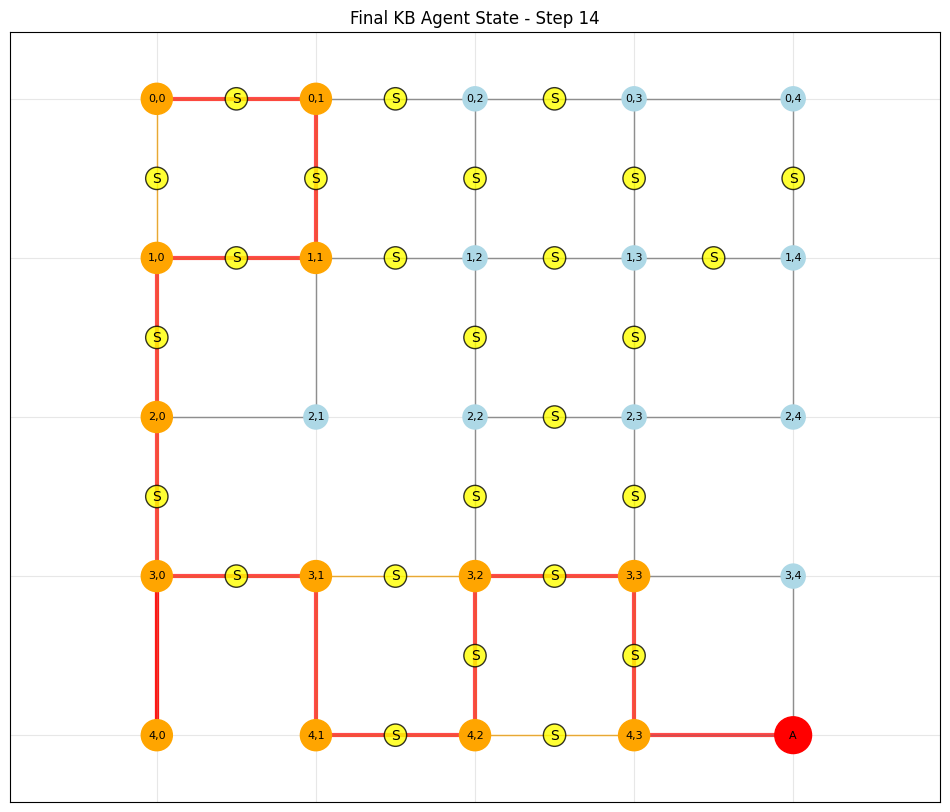


Knowledge Base Summary:
total_facts: 89
known_connections: 19
road_signs: 38
visited_intersections: 13


In [7]:
road_graph = RoadGraphWithSigns(size=5, edges_to_remove=4)
start_pos = (0, 0)
target_pos = (4, 4)

print("Road graph with signs created:", road_graph.size, "x", road_graph.size)
print("Removed edges:", len(road_graph.removed_edges))
print("Total road signs:", len(road_graph.road_signs))

kb_agent = KnowledgeBasedAgent(road_graph, start_pos, target_pos)

visualize_kb_agent_ascii(road_graph, kb_agent)
animate_kb_agent(road_graph, kb_agent)

## Порівняння з простим агентом

In [8]:
class SimpleAgent:
    def __init__(self, road_graph, start, target):
        self.road_graph = road_graph
        self.current_position = start
        self.target_position = target
        self.visited = set()
        self.memory = {}
        self.steps = 0
        
    def perceive(self):
        neighbors = self.road_graph.get(self.current_position, [])
        self.memory[self.current_position] = neighbors
        self.visited.add(self.current_position)
        return neighbors
        
    def choose_action(self):
        self.steps += 1
        if self.current_position == self.target_position:
            return None
            
        neighbors = self.perceive()
        unvisited = [n for n in neighbors if n not in self.visited]
        
        if unvisited:
            return random.choice(unvisited)
        elif neighbors:
            return random.choice(neighbors)
        return None
        
    def run(self, max_steps=100):
        while self.steps < max_steps:
            if self.current_position == self.target_position:
                return True
            action = self.choose_action()
            if action:
                self.current_position = action
            else:
                break
        return False

print("\nComparison test:")

simple_agent = SimpleAgent(road_graph.graph, (0, 0), (4, 4))
simple_success = simple_agent.run()
print(f"Simple agent: {'SUCCESS' if simple_success else 'FAILED'} in {simple_agent.steps} steps")

kb_agent2 = KnowledgeBasedAgent(road_graph, (0, 0), (4, 4))
kb_success = kb_agent2.run_kba_algorithm()
print(f"KB agent: {'SUCCESS' if kb_success else 'FAILED'} in {kb_agent2.steps} steps")

print(f"\nKB agent knowledge summary:")
summary = kb_agent2.get_knowledge_summary()
for key, value in summary.items():
    print(f"  {key}: {value}")


Comparison test:
Simple agent: SUCCESS in 28 steps
kb agent init: (0, 0) -> (4, 4)
starting kb agent at (0, 0)
sign: (0, 0)->(0, 1) leads to (0, 1) with ['east', 'south', 'west']
sign: (0, 0)->(1, 0) leads to (1, 0) with ['east', 'south', 'north']
kb: exploring (0, 1)
sign: (0, 1)->(0, 2) leads to (0, 2) with ['east', 'south', 'west']
sign: (0, 1)->(1, 1) leads to (1, 1) with ['east', 'south', 'west', 'north']
sign: (0, 1)->(0, 0) leads to (0, 0) with ['east', 'south']
kb: exploring (1, 1)
sign: (1, 1)->(1, 2) leads to (1, 2) with ['east', 'south', 'west', 'north']
sign: (1, 1)->(2, 1) leads to (2, 1) with ['west', 'north']
sign: (1, 1)->(1, 0) leads to (1, 0) with ['east', 'south', 'north']
sign: (1, 1)->(0, 1) leads to (0, 1) with ['east', 'south', 'west']
kb: exploring (2, 1)
sign: (2, 1)->(2, 0) leads to (2, 0) with ['east', 'south', 'north']
sign: (2, 1)->(1, 1) leads to (1, 1) with ['east', 'south', 'west', 'north']
kb: exploring (2, 0)
sign: (2, 0)->(2, 1) leads to (2, 1) with 

## Демонстрація операцій TELL/ASK

In [9]:
print("\nDemonstrating TELL/ASK operations:")

kb = KnowledgeBase()

print("\nTELL operations:")
kb.tell({'type': 'connection', 'from': (0, 0), 'to': (0, 1)})
print("told: connection (0,0) -> (0,1)")

kb.tell({'type': 'road_sign', 'road': ((0, 0), (0, 1)), 'target': (0, 1), 'directions': ['north', 'south', 'east']})
print("told: road sign with 3 directions")

kb.tell({'type': 'visited', 'intersection': (0, 0)})
print("told: visited (0,0)")

print(f"\nTotal facts in KB: {len(kb.facts)}")

print("\nASK operations:")
path_result = kb.ask({'type': 'path_to_target', 'start': (0, 0), 'target': (0, 1)})
print(f"asked: path from (0,0) to (0,1) -> {path_result}")

exploration_result = kb.ask({'type': 'best_exploration', 'current': (0, 0)})
print(f"asked: best exploration from (0,0) -> {exploration_result}")

sign_result = kb.ask({'type': 'road_sign_info', 'road': ((0, 0), (0, 1))})
print(f"asked: road sign info -> {sign_result}")


Demonstrating TELL/ASK operations:

TELL operations:
told: connection (0,0) -> (0,1)
told: road sign with 3 directions
told: visited (0,0)

Total facts in KB: 3

ASK operations:
asked: path from (0,0) to (0,1) -> [(0, 0), (0, 1)]
asked: best exploration from (0,0) -> (0, 1)
asked: road sign info -> {'target': (0, 1), 'directions': ['north', 'south', 'east']}


## Тестування ефективності

In [10]:
def compare_agents(num_tests=5):
    kb_results = []
    simple_results = []
    
    for i in range(num_tests):
        road_graph = RoadGraphWithSigns(size=4, edges_to_remove=random.randint(2, 6))
        start = (0, 0)
        target = (3, 3)
        
        kb_agent = KnowledgeBasedAgent(road_graph, start, target)
        kb_success = kb_agent.run_kba_algorithm(max_steps=50)
        kb_results.append({
            'success': kb_success,
            'steps': kb_agent.steps,
            'knowledge_facts': len(kb_agent.knowledge_base.facts)
        })
        
        simple_agent = SimpleAgent(road_graph.graph, start, target)
        simple_success = simple_agent.run(max_steps=50)
        simple_results.append({
            'success': simple_success,
            'steps': simple_agent.steps
        })
        
        print(f"Test {i+1}: KB={'SUCCESS' if kb_success else 'FAIL'}({kb_agent.steps}) vs Simple={'SUCCESS' if simple_success else 'FAIL'}({simple_agent.steps})")
    
    kb_success_rate = sum(1 for r in kb_results if r['success']) / num_tests
    simple_success_rate = sum(1 for r in simple_results if r['success']) / num_tests
    
    kb_avg_steps = sum(r['steps'] for r in kb_results if r['success']) / max(1, sum(1 for r in kb_results if r['success']))
    simple_avg_steps = sum(r['steps'] for r in simple_results if r['success']) / max(1, sum(1 for r in simple_results if r['success']))
    
    print(f"\nResults summary:")
    print(f"KB Agent - Success: {kb_success_rate:.0%}, Avg steps: {kb_avg_steps:.1f}")
    print(f"Simple Agent - Success: {simple_success_rate:.0%}, Avg steps: {simple_avg_steps:.1f}")
    
    if kb_results:
        avg_facts = sum(r['knowledge_facts'] for r in kb_results) / len(kb_results)
        print(f"KB Agent avg knowledge facts: {avg_facts:.1f}")

print("Performance comparison:")
compare_agents()

Performance comparison:
всього ребер: 24
запитано видалити: 4 ребер
фактично видалено: 4 ребер із 4 запитаних
граф зв'язний: ТАК ✓
kb agent init: (0, 0) -> (3, 3)
starting kb agent at (0, 0)
sign: (0, 0)->(0, 1) leads to (0, 1) with ['east', 'south', 'west']
sign: (0, 0)->(1, 0) leads to (1, 0) with ['south', 'north']
kb: exploring (0, 1)
sign: (0, 1)->(0, 2) leads to (0, 2) with ['east', 'south', 'west']
sign: (0, 1)->(1, 1) leads to (1, 1) with ['east', 'south', 'north']
sign: (0, 1)->(0, 0) leads to (0, 0) with ['east', 'south']
kb: exploring (1, 1)
sign: (1, 1)->(1, 2) leads to (1, 2) with ['south', 'west', 'north']
sign: (1, 1)->(2, 1) leads to (2, 1) with ['east', 'west', 'north']
sign: (1, 1)->(0, 1) leads to (0, 1) with ['east', 'south', 'west']
kb: exploring (2, 1)
sign: (2, 1)->(2, 2) leads to (2, 2) with ['south', 'west', 'north']
sign: (2, 1)->(2, 0) leads to (2, 0) with ['east', 'south', 'north']
sign: (2, 1)->(1, 1) leads to (1, 1) with ['east', 'south', 'north']
kb: expl

## Висновки

Реалізований агент на основі знань демонструє наступні переваги:

1. **Структурована база знань**: використовує операції TELL/ASK для керування знаннями
2. **Розширена інформація**: обробляє дорожні знаки для кращого планування
3. **Ефективне планування**: використовує накопичені знання для оптимальних рішень
4. **Адаптивність**: може працювати з неповною інформацією та поступово навчатися

Агент успішно інтегрує принципи Knowledge-Based AI для навігації в складному середовищі.